In [8]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra
from pyiga import algebra_cy

from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/wolfman/miniforge3/lib/python3.11/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['hstack', 'identity']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [9]:
class IetiMapper:
    def __init__(self, MP, dir_data, neu_data=None, elim=False):
        self.space = MP
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos

        # self.elim=elim

        # if self.elim:
        #     p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
        #     self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        # else:
            #self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]
        self.B = self.space.B
        self.N = self.space.N
        self.N_ofs = self.space.N_ofs

        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]

        nnz_per_col = self.B.getnnz(axis=0)
        self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.space.global_dir_idx)
        self.skeleton = np.union1d(self.intfs, self.space.global_dir_idx)
        
        self.Rbb = []
        self.Rii = []
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask = np.zeros(self.N[p], dtype=bool)
            nnz_per_col = self.Bk[p].getnnz(axis=0)
            if p in self.space.dir_idx:
                intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.space.dir_idx[p])
            else:
                intfs = np.where(nnz_per_col > 0)[0]
            mask[intfs]=True
            if p in self.space.dir_idx:
                mask[self.space.dir_idx[p]]=False
            self.Rbb.append(Id[mask].tocsc())
            mask = np.ones(self.N[p], dtype=bool)
            mask[intfs]=False
            if p in self.space.dir_idx:
                mask[self.space.dir_idx[p]]=False
            self.Rii.append(Id[mask].tocsc())
            
        #self.Nodes = self.get_nodes()

    def get_nodes(self, dir_boundary=False):      ###TODO: make it dependent on a constraint matrix not on the precomputed Basis matrix
        """Get global vertices of the multipatch object as well as local nodal degrees of freedom corresponding to the vertices. 
        In case of T-junctions also obtain the $p$ global degrees of freedom and $p$ local degrees of freedom on the coarse patch.
        Additionally may include nodes on the Dirichlet boundary if desired."""
        loc_c = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True) + self.N_ofs[p] for p, kvs in enumerate(self.space.mesh.kvs)])

        #loc_c = np.setdiff1d(loc_c, self.global_dir_idx)

        idx = (self.B[:,loc_c].getnnz(axis=1)==2)
        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),self.B.shape[1])).tocsr()
        c_B = self.B[idx,:]@R.T
        print(c_B.shape)
        nodal_indicator = R.T@algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=5).tocsc()
        nodal_indicator = nodal_indicator[:,nodal_indicator.getnnz(axis=0)>1]
        
        return np.split(nodal_indicator.indices, nodal_indicator.indptr[1:-1])
        
        # B = self.space.Basis[loc_c,:]
        # C_dofs = np.unique(B[B.getnnz(axis=1)==1].indices)
        # X = scipy.sparse.coo_matrix(self.space.Basis)
        # idx = np.where(np.isclose(X.data,1))
        # X.data, X.row, X.col = X.data[idx], X.row[idx], X.col[idx]
        # X = X.tocsc()
        # self.Nodes = {c:[X[:,c].indices] for c in C_dofs}
        # t_idx = loc_c[np.where(B.getnnz(axis=1)>1)[0]]
        # T_dofs = {}
        # for i in t_idx:
        #     t = tuple(self.space.Basis[i,:].indices)
        #     coeff = tuple()
        #     if t not in T_dofs:
        #         T_dofs[t] = [(i,),set(self.space.B[self.space.B.tocsc()[:,i].indices,:].indices)-{i}]
        #     else:
        #         T_dofs[t][0] = T_dofs[t][0]+(i,)
        #         T_dofs[t][1] = T_dofs[t][1] & (set(self.space.B[self.space.B.tocsc()[:,i].indices,:].indices)-{i})
        # T_dofs = {t:[np.sort(T_dofs[t][0]),np.sort(list(T_dofs[t][1]))] for t in T_dofs}
        # self.Nodes.update(T_dofs)
        # if not dir_boundary:
        #     self.Nodes = {key:self.Nodes[key] for key in self.Nodes if len(np.intersect1d(self.Nodes[key][0],self.space.global_dir_idx))==0}
        

    def generate_primal_info(fat):      ###TODO: more efficient
        #Nodes = self.space.get_nodes()
        self.Prim = {}
        i=0
        total_dofs=set()
        
        if self.elim:
            if fat:
                for key in self.Nodes:
                    if isinstance(key,np.int32):
                        dofs = self.Basis.tocsr()[self.Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        dofs = self.Basis.tocsr()[self.Nodes[key][1],:].indices
                        for dof in dofs:
                            if dof not in total_dofs:
                                total_dofs.add(dof)
                                dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                                self.Prim[i] = (dofs,np.ones(len(dofs)))
                                i+=1
            else:
                for key in self.Nodes:
                    if isinstance(key,np.int32):
                        dofs = self.Basis.tocsr()[self.Nodes[key][0],:].indices
                        self.Prim[i] = (dofs,np.ones(len(dofs)))
                        i+=1
                    else:
                        constr = (self.space.B.tocsc()[:,self.Nodes[key][0][0]]==1).indices
                        coeffs = abs(self.space.B[constr,:][:,self.Nodes[key][1]].data)
                        dofs_coarse = self.Basis.tocsr()[self.Nodes[key][1],:].indices
                        dofs=[]
                        for dof in dofs_coarse:
                            found_dofs = np.unique(self.B.tocsr()[self.B.tocsc()[:,dof].indices,:].indices)
                            dofs.append(found_dofs)
                        self.Prim[i] = (np.concatenate(dofs),np.repeat(coeffs,len(found_dofs)))
                        i+=1
        else:
            for key in self.Nodes:
                if isinstance(key,np.int32):    #regular corner
                    dofs = self.Basis.tocsr()[self.Nodes[key][0],:].indices
                    self.Prim[i] = (dofs,np.ones(len(dofs)))
                    i+=1
                else:                        #T-junction
                    constr = (self.space.B.tocsc()[:,self.Nodes[key][0][0]]==1).indices
                    coeffs = abs(self.space.B[constr,:][:,self.Nodes[key][1]].data)
                    dofs_coarse = self.Nodes[key][1]
                    dofs=np.concatenate([self.Nodes[key][0],self.Nodes[key][1]])
                    coeffs = np.concatenate([np.ones(len(self.Nodes[key][0])),coeffs])
                    self.Prim[i] = (dofs,coeffs)
                    i+=1
        #self.n_prim = len(Prim)

In [297]:
deg = 1
N = 3
#M = Tshapes(deg,N,1)
knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
M.split_patch(0,axis=0);
M.split_patch(1,axis=1);
#M.h_refine({1:-1})
M.split_patch(0,axis=1);
MP = assemble.Multipatch(M, automatch=True)
dir_data = {0:0}
MP.set_dirichlet_boundary(dir_data)
IMP = IetiMapper(MP,dir_data)

setting up constraints took 0.015811681747436523 seconds.
Basis setup took 0.005078315734863281 seconds
(8, 16)


In [298]:
t = time.time()
Basis = IMP.get_nodes()
print(Basis)
print(time.time()-t)

(8, 16)
[array([ 3, 48], dtype=int32), array([12, 16], dtype=int32), array([31, 44], dtype=int32), array([32, 15, 19, 60], dtype=int32), array([35, 63], dtype=int32)]
0.014004707336425781


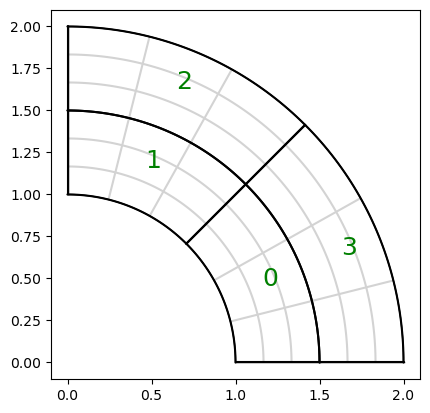

In [299]:
M.draw(knots=1, patch_idx=1)

In [300]:
corner = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True) + MP.N_ofs[p] for p, kvs in enumerate(MP.mesh.kvs)])
n = MP.B.shape[1]

In [301]:
idx = (MP.B[:,corner]>0).getnnz(1)>0
B = MP.B[idx,:]
B = B[B.getnnz(1)==2,:]
loc_c = np.unique(B.indices)
R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
c_B = B@R.T

R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
nodal_indicator = algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=5)
dofs = np.empty(nodal_indicator.shape[1], dtype=np.int32)
S = c_B.sum(0).A[0]
for j in range(nodal_indicator.shape[1]):
    ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
    dofs[j]=R.indices[ind[np.argmax(S[ind])]]
nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]
nnz = MP.B.getnnz(1)
B = MP.B.tocsc()
constr = np.repeat(-1,len(dofs))

for j in range(nodal_indicator.shape[1]):
    dof=dofs[j]
    for r in range(B.indptr[dof],B.indptr[dof+1]):
        i=B.indices[r]
        if nnz[i]>2:
            constr[j]=i
            break
if any(constr!=-1):
    print(1)
    idx = np.where(constr!=-1)[0]
    res = scipy.sparse.csc_matrix(nodal_indicator.shape)
    res[:,idx]=abs(MP.B[constr[idx],:]).T
    res.data=abs(res.data-1)
    res.eliminate_zeros()
    nodal_indicator += res

In [302]:
print(nodal_indicator[:,2])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2 stored elements and shape (64, 1)>
  Coords	Values
  (31, 0)	1.0
  (44, 0)	1.0


In [258]:
idx=np.where(constr!=-1)[0]

In [259]:
idx

array([2])

In [270]:
res = scipy.sparse.csc_matrix(nodal_indicator.shape)

In [274]:
res[:,idx]=abs(MP.B[constr[idx],:]).T

/home/wolfman/miniforge3/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [280]:
res.data=abs(res.data-1)

In [282]:
res.data

array([0.5, 0.5, 0. ])

In [272]:
abs(MP.B[constr[idx],:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 81)>

In [273]:
res[:,idx]

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 0 stored elements and shape (81, 1)>

In [214]:
idx

array([-1, -1, -1, -1])

In [135]:
B.toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [120]:
np.argmax(np.array([-1,0,1]))

2

In [118]:
c_B[:,[2,4,6,10]].sum(0)

matrix([[-2.,  0.,  0.,  2.]])

In [92]:
nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]

In [88]:
c_B

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 8)>

In [86]:
for j in range(nodal_indicator.shape[1]):
    ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
    

# dofs = nodal_indicator.indices
# nnz = MP.B.getnnz(1)
# B = MP.B.tocsc()
# idx = np.zeros(len(dofs))-1

# for k,dof in enumerate(dofs):
#     for r in range(B.indptr[dof],B.indptr[dof+1]):
#         i = B.indices[r]
#         if nnz[i]>2 and np.isclose(B.data[r],1): 
#             idx[k] = i
# #idx = MP.Constr[:,dofs].tocsc().indices
# #nnz = MP.Constr.getnnz(1)

[12 16]
[15 35]
[19 32]
[31 44]


In [87]:
ind

array([31, 44], dtype=int32)

In [82]:
dofs

array([12, 16, 15, 35, 19, 32, 31, 44], dtype=int32)

In [83]:
B[:,dofs].toarray()

array([[-1. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -1. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -1. ,  1. ,  0. ,  0. ,  0. ,  0. ]])

In [84]:
idx

array([-1., -1., -1., -1.,  3.,  8., -1., -1.])

In [54]:
print(B[:,12])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2 stored elements and shape (12, 1)>
  Coords	Values
  (0, 0)	-1.0
  (1, 0)	-0.5


In [25]:
B.indices[B.indptr[dofs[2]]:B.indptr[dofs[2]+1]]

array([3, 4], dtype=int32)

In [84]:
idx = MP.Constr[:,dofs].tocsc().indices

In [26]:
B[:,dofs].toarray()

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [75]:
nnz

array([2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2], dtype=int32)

In [74]:
nnz

array([2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2], dtype=int32)

In [31]:
dofs

array([16, 35, 32, 44], dtype=int32)

In [41]:
B.toarray()

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5, -0.5,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,

In [19]:
idx1 = MP.Constr.tocsc()[:,dofs].getnnz(1)>0

In [20]:
idx1

array([ True, False, False, False,  True, False, False,  True,  True, False, False,  True])

In [248]:
B = MP.Constr[idx,:]

In [249]:
B.toarray()

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5, -0.5,  0. ,  0. ,

In [250]:
MP.Constr[idx,:][MP.Constr[idx,:].getnnz(1)>0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11 stored elements and shape (5, 48)>

In [251]:
nodal_indicator.indptr[:-1]

array([0, 2, 4, 6], dtype=int32)

In [252]:
np.where(idx2)

(array([1, 2, 3, 4, 5]),)

In [126]:
idx2=np.unique(1*((MP.Constr@R.T@R)==1).tocsc().indices)
corner_dofs = np.unique(MP.Constr[idx2,:].indices)

In [127]:
corner_dofs

array([12, 13, 14, 15, 16, 19, 31, 32, 38, 74], dtype=int32)

In [125]:
np.unique(MP.Constr[idx2,:].indices)

array([12, 13, 14, 15, 16, 19, 31, 32, 38, 74], dtype=int32)

In [73]:
MP.Constr.data

array([-1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -1. ,  1. , -1. ,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. ])

In [44]:
MP.Constr.data[MP.Constr.data==-1]=0

In [47]:
MP.Constr[:,loc_c]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (12, 12)>

In [45]:
MP.Constr[:,loc_c]+1*(MP.Constr[:,loc_c]!=0)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (12, 12)>

In [30]:
idx2 = (MP.Constr[:,loc_c].getnnz(axis=1)>0)

In [32]:
np.where(idx2)

(array([ 0,  1,  3,  4,  7,  8, 10, 11]),)

In [37]:
print((abs(MP.Constr)-1*(MP.Constr!=0))[idx2,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (8, 48)>
  Coords	Values
  (1, 12)	-0.5
  (1, 13)	-0.5
  (2, 13)	-0.5000000000000001
  (2, 14)	-0.5
  (5, 13)	-0.5000000000000001
  (5, 14)	-0.5
  (6, 14)	-0.4999999999999999
  (6, 15)	-0.5000000000000002


In [27]:
np.where(idx)

(array([ 0,  4,  7, 11]),)

In [385]:
c_Basis

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 16 stored elements and shape (36, 9)>

In [386]:
c_Basis[:,c_Basis.getnnz(axis=0)>1]

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 12 stored elements and shape (36, 5)>

In [387]:
dofs = c_Basis[:,c_Basis.getnnz(axis=0)>1].indices

In [388]:
sec = c_Basis[:,c_Basis.getnnz(axis=0)>1].indptr

In [389]:
dofs

array([27,  2,  9,  6, 24, 17, 33, 18, 11,  8, 35, 20], dtype=int32)

In [390]:
sec

array([ 0,  2,  4,  6, 10, 12], dtype=int32)

In [391]:
np.split(dofs, sec[1:-1])

[array([27,  2], dtype=int32),
 array([9, 6], dtype=int32),
 array([24, 17], dtype=int32),
 array([33, 18, 11,  8], dtype=int32),
 array([35, 20], dtype=int32)]

In [19]:
# x = np.zeros(n)
# x[loc_c] = 1
# R = scipy.sparse.spdiags(x,0,n,n)
# B_ = MP.Constr@R

In [20]:
#fine_dofs = np.unique((B_==1).tocsr().indices)

In [21]:
#np.unique(fine_dofs)

In [22]:
#idx2 = np.unique(MP.Constr[:,fine_dofs].tocsc().indices)

In [23]:
#B = MP.Constr[idx2,:]

In [24]:
#B[B.getnnz(1)>2].toarray()

In [25]:
Basis = algebra_cy.pyx_compute_basis(B.shape[0], B.shape[1], B, maxiter=5).tocsc()

In [26]:
Basis = Basis[:,Basis.getnnz(axis=0)>1]

In [27]:
Basis.shape

(48, 5)

In [28]:
Basis.toarray()

array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0

In [450]:
fine_dofs = Basis.indices[Basis.indptr[:-1]]

In [235]:
sys.setrecursionlimit(100000)
N = 1000
A = np.random.rand(N,N)
L = 10000*[aslinearoperator(A)]
S = np.array(L).sum()
x = np.random.rand(N)

In [236]:
%timeit S@x

550 ms ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [237]:
X = SumOperator(L)

In [238]:
%timeit X@x

505 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
X

<3x2 SumOperator with dtype=int64>

In [154]:
L[0].dtype

dtype('int64')

In [140]:
np.all((np.array([s.shape for s in L])-np.tile(L[0].shape,len(L)).reshape(-1,2))==0)

True

In [198]:
class SumOperator(scipy.sparse.linalg.LinearOperator):
    """A :class:`LinearOperator` which implements the 
    application of an arbitrary sum of given input operators 
    without(!) using recursive structures.
    """
    def __init__(self, ops):
        self.N = len(ops)
        assert np.all((np.array([op.shape for op in ops])-np.tile(ops[0].shape,self.N).reshape(-1,2))==0)
        self.ops = ops
        self.shape = ops[0].shape
        scipy.sparse.linalg.LinearOperator.__init__(self, ops[0].dtype, self.shape)
        
    def _matvec(self, x):
        return np.array([op@x for op in self.ops]).sum(axis=0)

    def _transpose(self):
        return SumOperator([op.T for op in self.ops])
        

In [128]:
np.all(np.array([1,1,1])==1)

True

In [136]:
np.tile(L[0].shape,len(L)).reshape(-1,2)

array([[3, 2],
       [3, 2],
       [3, 2]])